In [191]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, plot_confusion_matrix, log_loss, make_scorer, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold, RandomizedSearchCV
pd.set_option('display.max_columns', None)
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [82]:
df = pd.read_csv('/Users/morganabbitt/galvanize/capstone/NFL-Analytics/data/NFL Play by Play 2009-2018 (v5).csv', low_memory=False)
#drop when the play is the last of the quarter
df = df[df['quarter_end'] == 0]
#grab all 4th downs
df_4 = df[df['down'] == 4.0]
#convert date to datetime
date = pd.to_datetime(df_4['game_date'].values)
#separate date and year
df_4['game_date'] = date
df_4['year'] = date.year
df_4 = df_4[df_4['play_type'] != 'no_play']
df_4 = df_4[['yardline_100', 'half_seconds_remaining', 'posteam_type', 'drive', 'qtr', 
            'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'play_type',
             'score_differential', 'ep', 'posteam_score', 'defteam_score', 'no_huddle', 'year']]
#creates dummy columns for categorical variables and merges back to original along indicies
df_4 = pd.get_dummies(df_4['posteam_type']).merge(df_4.drop(columns='posteam_type'), left_index=True, right_index=True)
#0 is punt
df_4.loc[df_4['play_type'] == 'punt', 'target'] = 1
#1 is field goal
df_4.loc[df_4['play_type'] == 'field_goal', 'target'] = 0
#2 is go for it
df_4.loc[(df_4['play_type'] == 'run') | (df_4['play_type'] == 'pass') | (df_4['play_type'] == 'qb_kneel'), 'target'] = 2

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [83]:
df_4

,away,home,yardline_100,half_seconds_remaining,drive,qtr,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,play_type,score_differential,ep,posteam_score,defteam_score,no_huddle,year,target
4,0,1,56.0,1707.0,1,1,8,3.0,3.0,punt,0.0,-0.699436,0.0,0.0,0,2009,1.0
8,1,0,96.0,1594.0,2,1,8,3.0,3.0,punt,0.0,-3.393288,0.0,0.0,0,2009,1.0
14,0,1,41.0,1405.0,3,1,21,3.0,3.0,punt,0.0,0.757343,0.0,0.0,0,2009,1.0
20,1,0,19.0,1308.0,4,1,7,3.0,3.0,field_goal,0.0,2.487035,0.0,0.0,0,2009,0.0
24,0,1,79.0,1202.0,5,1,16,3.0,3.0,punt,0.0,-2.604561,0.0,0.0,0,2009,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449301,0,1,85.0,1602.0,14,3,12,3.0,2.0,punt,1.0,-3.000972,7.0,6.0,0,2018,1.0
449310,1,0,53.0,1363.0,15,3,8,2.0,3.0,punt,-1.0,-0.306871,6.0,7.0,0,2018,1.0
449341,0,1,58.0,536.0,18,4,16,3.0,2.0,punt,-5.0,-0.597099,7.0,12.0,0,2018,1.0
449355,1,0,14.0,150.0,19,4,1,1.0,2.0,run,5.0,2.199064,12.0,7.0,0,2018,2.0


In [204]:
def cross_val(estimator, X, y):
    '''
    estimator = The model you want to use with the sepcified paramters
                        ex: LogisticRegression(), RandomForestClassification() ...
                        
    data = clean dataframe you are working with, no nans
    
    clean_features = list of features you want to observe in your model
    
    target = target column you want to predict against
    '''

    kf = KFold(n_splits=5, shuffle=True, random_state=123)  # almost always use shuffle=True
    acc_scores = []
    f1_scores = []
    model = estimator   
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_test_pred))
        f1_scores.append(f1_score(y_test, y_test_pred, average='micro'))
        #precision_scores.append(precision_score(y[test], y_test_pred))
        #test_matrix = confusion_matrix(y[test], y_test_pred)
    print('F1 Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(f1_scores)))
    print('Accuracy Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(acc_scores)))
    #print('Recall Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(recall_scores)))
    #print('Precision Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(precision_scores)))
    return model 

In [85]:
#if working with RandomForests dont need to drop na, else dropna
test = df_4[df_4['year'] == 2018].dropna()
train = df_4[(df_4['year'] == 2017) | (df_4['year'] == 2016) | (df_4['year'] == 2015) | (df_4['year'] == 2014) | (df_4['year'] == 2013)].dropna()

y_test = test['target']
X_test = test.drop(columns=['target', 'play_type']) #.select_dtypes(exclude=['object'])

y_train = train['target']
X_train = train.drop(columns=['target', 'play_type']) #.select_dtypes(exclude=['object'])

In [87]:
rf = cross_val(RandomForestClassifier(), X_train.values, y_train.values)

Accuracy Mean Score of RandomForestClassifier: 0.944


In [88]:
rf.predict(X_test.values)

array([2., 1., 0., ..., 1., 2., 2.])

In [118]:
features = rf.feature_importances_.reshape(-1, 1)

In [119]:
features

array([[0.00363507],
       [0.0035791 ],
       [0.37009224],
       [0.04790638],
       [0.02560262],
       [0.01465053],
       [0.05688839],
       [0.01675185],
       [0.00833944],
       [0.05067445],
       [0.31852093],
       [0.02052544],
       [0.03630737],
       [0.01512553],
       [0.01140066]])

In [156]:
fi = pd.DataFrame(data=features, index=X_train.columns)
fi.sort_values(by=0, inplace=True)
fi.index

Index(['home', 'away', 'defteam_timeouts_remaining', 'year', 'qtr',
       'no_huddle', 'posteam_timeouts_remaining', 'posteam_score', 'drive',
       'defteam_score', 'half_seconds_remaining', 'score_differential',
       'ydstogo', 'ep', 'yardline_100'],
      dtype='object')

In [157]:
lst = []
index = []
for arr in fi.values.reshape(1,-1):
    for x in arr:
        lst.append(x)
for ind in fi.index:
    index.append(ind)

<BarContainer object of 15 artists>

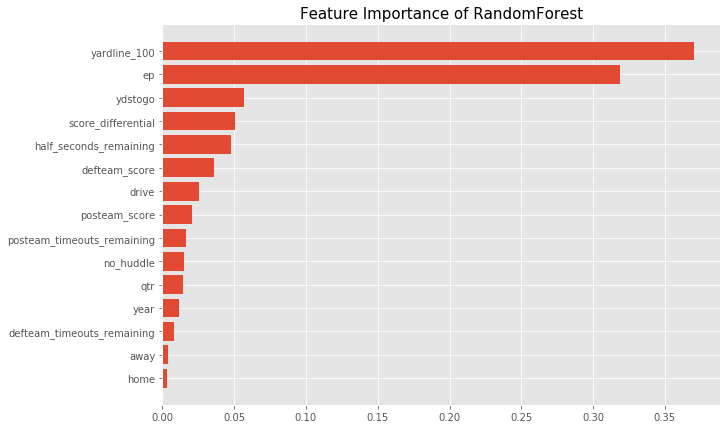

In [164]:
plt.figure(figsize=(10,7))
plt.title('Feature Importance of RandomForest', size=15)
plt.barh(index, lst)

In [90]:
cm = confusion_matrix(y_test, rf.predict(X_test.values))

In [91]:
cm_normal = np.round(cm / cm.sum(axis=0), decimals=3)

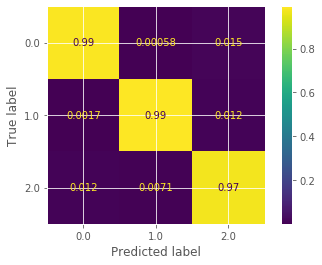

In [165]:
plot_confusion_matrix(rf, X_train.values, y_train.values, normalize='pred')

<Figure size 1440x1440 with 0 Axes>

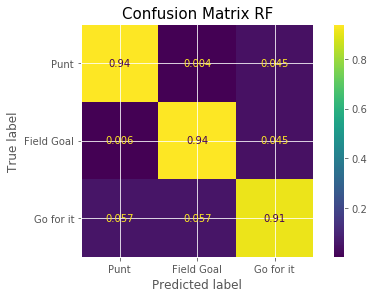

In [92]:
plt.figure(figsize=(20,20))
ConfusionMatrixDisplay(cm_normal, ['Punt', 'Field Goal', 'Go for it']).plot()
plt.tight_layout()
plt.title('Confusion Matrix RF', size=15);

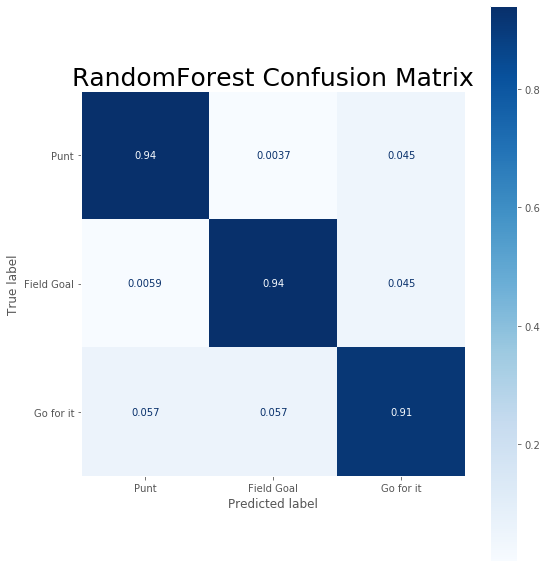

In [180]:
fig, ax = plt.subplots(1, figsize=(8,8))
conf = plot_confusion_matrix(rf,X_test,y_test,normalize='pred',cmap='Blues',display_labels=np.array(['Punt','Field Goal', 'Go for it']), ax=ax)
conf.ax_.grid(False)
conf.ax_.set_title('RandomForest Confusion Matrix', size=25)
plt.tight_layout()

In [196]:
# parameter space for randomized grid search
n_estimators = [50, 100, 200]
max_features = ['log2', 'sqrt', None]
max_depth = [2, 3, 6]
min_samples_split = [2, 4, 8]
min_samples_leaf = [1, 2, 4]
learning_rate  = [0.1, 0.05, 0.025]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
scorer = make_scorer(f1_score, average = 'micro')
# create 20 gbc objects to be tuned and fitted
rf1 = RandomForestClassifier()
clf = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 10, scoring=scorer, n_jobs = -1, cv = 5, verbose=0)

In [197]:
clf.fit(X_train.values, y_train.values)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [198]:
clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 6}

In [205]:
cross_val(RandomForestClassifier(n_estimators=100, min_samples_leaf=1, min_samples_split=2, max_features=None, max_depth=6), X_train.values, y_train.values)

F1 Mean Score of RandomForestClassifier: 0.927
Accuracy Mean Score of RandomForestClassifier: 0.927


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [212]:
cross_val(LogisticRegression(max_iter=100, solver='newton-cg', multi_class='multinomial'), X_train.values, y_train.values)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearc

F1 Mean Score of LogisticRegression: 0.884
Accuracy Mean Score of LogisticRegression: 0.884


/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)